# Age of Empires 2 Stats

In [889]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [725]:
# TODO: 
#     Figure out if the game time is in real time or game time

# Getting game data
profile_id = 76561198021376709
resp_games = requests.get('https://aoe2.net/api/player/matches?game=aoe2de&steam_id=' + str(profile_id) + '&count=1000').json()
df = pd.json_normalize(resp_games)

# Getting definitions used in the API
definitions = requests.get('https://aoe2.net/api/strings?game=aoe2de&language=en').json()

In [726]:
games_data = df[['num_players','game_type','map_type','ranked','rating_type','server','started','finished','players']]
games_data.head()

,num_players,game_type,map_type,ranked,rating_type,server,started,finished,players
0,2,0,140,True,2,ukwest,1590520287,1590531748,"[{'profile_id': 814137, 'steam_id': '765611982..."
1,2,0,140,True,2,westindia,1590518644,1590520382,"[{'profile_id': 211468, 'steam_id': '765611981..."
2,2,0,86,True,2,ukwest,1590517482,1590518837,"[{'profile_id': 289834, 'steam_id': '765611988..."
3,2,0,9,True,2,ukwest,1590515742,1590517638,"[{'profile_id': 235327, 'steam_id': '765611980..."
4,2,0,86,True,2,ukwest,1590513998,1590515825,"[{'profile_id': 372900, 'steam_id': '765611980..."


In [813]:
# Defining helper functions
def define_game_type(num_players):
    if num_players == 2:
        return '1v1'
    elif num_players == 4:
        return '2v2'
    elif num_players == 6:
        return '3v3'
    elif num_players == 8:
        return '4v4'
    else:
        return 'Other'

def age_map(map_id):
    for map_entry in definitions['map_type']:
        if map_entry['id'] == map_id:
            map_string = map_entry['string']
            break
    try:
        return map_string
    
    except:
        return 'Custom'
    
def civ(civ_id):
    for civ in definitions['civ']:
        if civ['id'] == civ_id:
            civ = civ['string']
            break
    try:
        return civ
    
    except:
        return 'Other'
    
def game_type(game_type_id):
    for game_type in definitions['game_type']:
        if game_type['id'] == game_type_id:
            game = game_type['string']
            break
    try:
        return game
    
    except:
        return 'Custom'
    
def ranking(ranking_type_id):
    for ranking_id in definitions['rating_type']:
        if ranking_id['id'] == ranking_type_id:
            ranking = ranking_id['string']
            break
    try:
        return ranking
    
    except:
        return 'Custom'
    
def game_time(start_time, finish_time):
    game_time = datetime.datetime.fromtimestamp(finish_time) - datetime.datetime.fromtimestamp(start_time)
    return game_time.seconds / 60

def player_data(player_dict):
    for player in player_dict:
        if player['steam_id'] == str(profile_id):
            own_civ = civ(player['civ'])
            own_rating = player['rating']
            won = player['won']
            is_drop = player['drops']
            own_team = player['team']
            rating_change = player['rating_change']
    
    opp_civ = None
    opp_no = 0
    opp_rating = 0
    for player in player_dict:
        if player['steam_id'] != str(profile_id) and player['team'] != own_team:
            if player['rating'] is not None:
                opp_rating+=player['rating']
                opp_no+=1
            if len(player_dict) == 2:
                opp_civ = civ(player['civ'])
    
    if opp_no == 0:
        avg_rating = None
    else:
        avg_rating = opp_rating / opp_no
    
    return own_civ, opp_civ, won, is_drop, rating_change, own_rating, avg_rating

# Fixing issues with lack of data on who won and on rating changes
def fix_win(games_rank_dataframe):
    for i in range(0, len(games_rank_dataframe)):
        if games_rank_dataframe.loc[i, 'won'] is None and games_rank_dataframe.loc[i, 'own_rating'] is not None and games_rank_dataframe.loc[i-1, 'own_rating'] is not None:
            games_rank_dataframe.loc[i, 'treated_win'] = 1 if games_rank_dataframe.loc[i, 'own_rating'] - games_rank_dataframe.loc[i-1, 'own_rating'] < 0 else 0
        else:
            games_rank_dataframe.loc[i, 'treated_win'] = 1 if games_rank_dataframe.loc[i, 'won'] == True else 0
            
def fix_rating_change(games_rank_dataframe):
    for i in range(0, len(games_rank_dataframe)):
        if games_rank_dataframe.loc[i, 'rating_change'] is None and games_rank_dataframe.loc[i, 'own_rating'] is not None and games_rank_dataframe.loc[i-1, 'own_rating'] is not None:
            games_rank_dataframe.loc[i, 'treated_rating_change'] = games_rank_dataframe.loc[i, 'own_rating'] - games_rank_dataframe.loc[i-1, 'own_rating']
        else:
            games_rank_dataframe.loc[i, 'treated_rating_change'] = games_rank_dataframe.loc[i, 'rating_change']
            
def fix_data_issues(games_rank_dataframe):
    fix_win(games_rank_dataframe)

In [728]:
games_data['map_type'] = games_data['map_type'].apply(lambda map_id: age_map(map_id))
games_data['game_type'] = games_data['game_type'].apply(lambda game_type_id: game_type(game_type_id))
games_data['rating_type'] = games_data['rating_type'].apply(lambda rating_type_id: ranking(rating_type_id))
games_data['vs_type'] = games_data['num_players'].apply(lambda num_players: define_game_type(num_players))
games_data['own_civ'], games_data['opp_civ'], games_data['won'], games_data['is_drop'], games_data['rating_change'], games_data['own_rating'], games_data['opp_rating'] = \
zip(*games_data['players'].apply(lambda player_dict: player_data(player_dict)))

C:\Users\nunoa\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\nunoa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nunoa\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [729]:
# Calculating game time
games_data['game_time'] = games_data.apply(lambda row: game_time(row['started'], row['finished']), axis = 1)

C:\Users\nunoa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [730]:
games_data.drop(['players', 'started', 'finished'], axis = 1, inplace = True)
games_data.head()

C:\Users\nunoa\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,num_players,game_type,map_type,ranked,rating_type,server,vs_type,own_civ,opp_civ,won,is_drop,rating_change,own_rating,opp_rating,game_time
0,2,Random Map,Four Lakes,True,1v1 Random Map,ukwest,1v1,Malians,Japanese,True,None,17,1433,1476,191.016667
1,2,Random Map,Four Lakes,True,1v1 Random Map,westindia,1v1,Malians,Persians,False,None,None,1467,1425,28.966667
2,2,Random Map,Serengeti,True,1v1 Random Map,ukwest,1v1,Magyars,Huns,False,None,-17,1467,1445,22.583333
3,2,Random Map,Arabia,True,1v1 Random Map,ukwest,1v1,Mayans,Bulgarians,False,None,-16,1483,1470,31.600000
4,2,Random Map,Serengeti,True,1v1 Random Map,ukwest,1v1,Magyars,Mongols,False,None,-16,1499,1499,30.450000


In [816]:
ranked_1v1 = games_data[games_data['rating_type'] == '1v1 Random Map'].reset_index(drop = True)
ranked_tgs = games_data[games_data['rating_type'] == 'Team Random Map'].reset_index(drop = True)

fix_data_issues(ranked_1v1)
fix_data_issues(ranked_tgs)

ranked_data = pd.concat([ranked_1v1, ranked_tgs])
ranked_data.drop('won', axis = 1, inplace = True)

ranked_1v1.replace([None], np.nan, inplace=True)
ranked_tgs.replace([None], np.nan, inplace=True)

## Winrate by civs

### 1v1 Ranked

In [882]:
ranked_1v1_civ_stats = ranked_1v1.groupby('own_civ')['treated_win'].count().reset_index()
ranked_1v1_civ_stats.columns = ['Civ', 'Total Games']
ranked_1v1_civ_stats['Wins'] = ranked_1v1.groupby('own_civ')['treated_win'].sum().values.astype(int)
ranked_1v1_civ_stats['Win Percentage'] = ranked_1v1.groupby('own_civ')['treated_win'].mean().values

ranked_1v1_civ_stats.sort_values(by = 'Total Games', ascending = False)\
.style.format("{:.0%}", subset = ['Win Percentage']).applymap(color_red_green,subset=['Win Percentage'])

,Civ,Total Games,Wins,Win Percentage
18,Mayans,12,11,92%
9,Huns,7,5,71%
3,Celts,4,4,100%
17,Malians,4,2,50%
20,Persians,4,2,50%
4,Chinese,3,3,100%
15,Magyars,3,0,0%
14,Lithuanians,3,0,0%
11,Japanese,3,0,0%
0,Berbers,2,0,0%


### 2v2 Ranked

In [880]:
ranked_2v2_civ_stats = ranked_tgs[ranked_tgs['vs_type'] == '2v2'].groupby('own_civ')['treated_win'].count().reset_index()
ranked_2v2_civ_stats.columns = ['Civ', 'Total Games']
ranked_2v2_civ_stats['Wins'] = ranked_tgs[ranked_tgs['vs_type'] == '2v2'].groupby('own_civ')['treated_win'].sum().values.astype(int)
ranked_2v2_civ_stats['Win Percentage'] = ranked_tgs[ranked_tgs['vs_type'] == '2v2'].groupby('own_civ')['treated_win'].mean().values

ranked_2v2_civ_stats.sort_values(by = 'Total Games', ascending = False)\
.style.format("{:.0%}", subset = ['Win Percentage']).applymap(color_red_green,subset=['Win Percentage'])

,Civ,Total Games,Wins,Win Percentage
9,Mayans,4,3,75%
7,Khmer,3,1,33%
13,Spanish,3,3,100%
1,Berbers,3,3,100%
16,Vietnamese,2,2,100%
11,Saracens,2,0,0%
17,Vikings,2,1,50%
6,Indians,2,1,50%
8,Koreans,1,1,100%
5,Ethiopians,1,0,0%


### 3v3 Ranked

In [883]:
ranked_3v3_civ_stats = ranked_tgs[ranked_tgs['vs_type'] == '3v3'].groupby('own_civ')['treated_win'].count().reset_index()
ranked_3v3_civ_stats.columns = ['Civ', 'Total Games']
ranked_3v3_civ_stats['Wins'] = ranked_tgs[ranked_tgs['vs_type'] == '3v3'].groupby('own_civ')['treated_win'].sum().values.astype(int)
ranked_3v3_civ_stats['Win Percentage'] = ranked_tgs[ranked_tgs['vs_type'] == '3v3'].groupby('own_civ')['treated_win'].mean().values

ranked_3v3_civ_stats.sort_values(by = 'Total Games', ascending = False)\
.style.format("{:.0%}", subset = ['Win Percentage']).applymap(color_red_green,subset=['Win Percentage'])

,Civ,Total Games,Wins,Win Percentage
1,Berbers,4,3,75%
4,Chinese,2,2,100%
10,Mongols,2,0,0%
0,Aztecs,1,0,0%
2,Bulgarians,1,1,100%
3,Burmese,1,0,0%
5,Cumans,1,1,100%
6,Goths,1,1,100%
7,Indians,1,1,100%
8,Magyars,1,1,100%


### 4v4 Ranked

In [884]:
ranked_4v4_civ_stats = ranked_tgs[ranked_tgs['vs_type'] == '4v4'].groupby('own_civ')['treated_win'].count().reset_index()
ranked_4v4_civ_stats.columns = ['Civ', 'Total Games']
ranked_4v4_civ_stats['Wins'] = ranked_tgs[ranked_tgs['vs_type'] == '4v4'].groupby('own_civ')['treated_win'].sum().values.astype(int)
ranked_4v4_civ_stats['Win Percentage'] = ranked_tgs[ranked_tgs['vs_type'] == '4v4'].groupby('own_civ')['treated_win'].mean().values

ranked_4v4_civ_stats.sort_values(by = 'Total Games', ascending = False)\
.style.format("{:.0%}", subset = ['Win Percentage']).applymap(color_red_green,subset=['Win Percentage'])

,Civ,Total Games,Wins,Win Percentage
2,Byzantines,3,1,33%
1,Berbers,2,1,50%
3,Celts,2,2,100%
5,Ethiopians,2,2,100%
12,Spanish,2,1,50%
0,Aztecs,1,1,100%
4,Cumans,1,1,100%
6,Huns,1,1,100%
7,Indians,1,0,0%
8,Japanese,1,0,0%


### TGs Ranked

In [860]:
ranked_tgs_civ_stats = ranked_tgs.groupby('own_civ')['treated_win'].count().reset_index()
ranked_tgs_civ_stats.columns = ['Civ', 'Total Games']
ranked_tgs_civ_stats['Wins'] = ranked_tgs.groupby('own_civ')['treated_win'].sum().values.astype(int)
ranked_tgs_civ_stats['Win Percentage'] = ranked_tgs.groupby('own_civ')['treated_win'].mean().values

ranked_tgs_civ_stats.sort_values(by = 'Total Games', ascending = False)\
.style.format("{:.0%}", subset = ['Win Percentage']).applymap(color_red_green,subset=['Win Percentage'])

,Civ,Total Games,Wins,Win Percentage
1,Berbers,9,7,78%
22,Spanish,5,4,80%
17,Mayans,4,3,75%
11,Indians,4,2,50%
0,Aztecs,3,2,67%
8,Ethiopians,3,2,67%
20,Saracens,3,1,33%
18,Mongols,3,0,0%
13,Khmer,3,1,33%
4,Byzantines,3,1,33%


In [732]:
win_rate = pd.pivot_table(ranked_data, values='treated_win', columns = 'vs_type', index=['own_civ'], aggfunc = [np.mean, 'count'])

win_rate.sort_values(by='Counted games',ascending=False)\
    .style.format("{:.0%}",subset=['Winrate'])\
    .applymap(color_red_green,subset=['Winrate'])

mean                           count               
vs_type           1v1       2v2   3v3       4v4   1v1  2v2  3v3  4v4
own_civ                                                             
Aztecs            NaN  1.000000  0.00  1.000000   NaN  1.0  1.0  1.0
Berbers      0.000000  1.000000  0.75  0.500000   2.0  3.0  4.0  2.0
Bulgarians   1.000000  0.000000  1.00       NaN   1.0  1.0  1.0  NaN
Burmese           NaN       NaN  0.00       NaN   NaN  NaN  1.0  NaN
Byzantines   1.000000       NaN   NaN  0.333333   1.0  NaN  NaN  3.0
Celts        1.000000       NaN   NaN  1.000000   4.0  NaN  NaN  2.0
Chinese      1.000000  1.000000  1.00       NaN   3.0  1.0  2.0  NaN
Cumans       0.500000  1.000000  1.00  1.000000   2.0  1.0  1.0  1.0
Ethiopians   0.500000  0.000000   NaN  1.000000   2.0  1.0  NaN  2.0
Franks       1.000000       NaN   NaN       NaN   1.0  NaN  NaN  NaN
Goths        0.500000       NaN  1.00       NaN   2.0  NaN  1.0  NaN
Huns         0.714286       NaN   NaN  1.000000   7.0  NaN  NaN  1.0
Incas        1.000000       NaN   NaN       NaN   2.0  NaN  NaN  NaN
Indians           NaN  0.500000  1.00  0.000000   NaN  2.0  1.0  1.0
Japanese     0.000000       NaN   NaN  0.000000   3.0  NaN  NaN  1.0
Khmer        1.000000  0.333333   NaN       NaN   1.0  3.0  NaN  NaN
Koreans      0.000000  1.000000   NaN  1.000000   2.0  1.0  NaN  1.0
Lithuanians  0.000000       NaN   NaN       NaN   3.0  NaN  NaN  NaN
Magyars      0.000000       NaN  1.00  1.000000   3.0  NaN  1.0  1.0
Malay        0.500000       NaN   NaN       NaN   2.0  NaN  NaN  NaN
Malians      0.500000       NaN  1.00       NaN   4.0  NaN  1.0  NaN
Mayans       0.916667  0.750000   NaN       NaN  12.0  4.0  NaN  NaN
Mongols      0.500000  0.000000  0.00       NaN   2.0  1.0  2.0  NaN
Persians     0.500000       NaN   NaN       NaN   4.0  NaN  NaN  NaN
Portuguese        NaN       NaN   NaN  1.000000   NaN  NaN  NaN  1.0
Saracens          NaN  0.000000  1.00       NaN   NaN  2.0  1.0  NaN
Slavs             NaN  1.000000  1.00       NaN   NaN  1.0  1.0  NaN
Spanish      1.000000  1.000000   NaN  0.500000   1.0  3.0  NaN  2.0
Tatars       0.000000  1.000000   NaN       NaN   1.0  1.0  NaN  NaN
Teutons      0.000000       NaN   NaN       NaN   2.0  NaN  NaN  NaN
Turks             NaN  0.000000   NaN       NaN   NaN  1.0  NaN  NaN
Vietnamese        NaN  1.000000   NaN       NaN   NaN  2.0  NaN  NaN
Vikings      1.000000  0.500000  1.00       NaN   1.0  2.0  1.0  NaN

## Winrate by civs against

In [826]:
ranked_1v1_civ_stats = ranked_1v1.groupby('opp_civ')['treated_win'].count().reset_index()
ranked_1v1_civ_stats.columns = ['Civ', 'Total Games']
ranked_1v1_civ_stats['Wins'] = ranked_1v1.groupby('opp_civ')['treated_win'].sum().values.astype(int)
ranked_1v1_civ_stats['Win Percentage'] = ranked_1v1.groupby('opp_civ')['treated_win'].mean().values

ranked_1v1_civ_stats.sort_values(by = 'Total Games', ascending = False)\
.style.format("{:.0%}", subset = ['Win Percentage']).applymap(color_red_green,subset=['Win Percentage'])

,Civ,Total Games,Wins,Win Percentage
18,Persians,9,3,33%
8,Huns,6,4,67%
6,Chinese,5,4,80%
12,Japanese,4,2,50%
17,Mongols,4,2,50%
24,Vikings,4,3,75%
7,Goths,3,3,100%
22,Teutons,3,1,33%
19,Slavs,3,2,67%
5,Celts,2,0,0%


## Winrate by maps

In [828]:
ranked_1v1_map_stats = ranked_1v1.groupby('map_type')['treated_win'].count().reset_index()
ranked_1v1_map_stats.columns = ['Map', 'Total Games']
ranked_1v1_map_stats['Wins'] = ranked_1v1.groupby('map_type')['treated_win'].sum().values.astype(int)
ranked_1v1_map_stats['Win Percentage'] = ranked_1v1.groupby('map_type')['treated_win'].mean().values

ranked_1v1_map_stats.sort_values(by = 'Total Games', ascending = False)\
.style.format("{:.0%}", subset = ['Win Percentage']).applymap(color_red_green,subset=['Win Percentage'])

,Map,Total Games,Wins,Win Percentage
2,Arabia,16,10,62%
4,Four Lakes,10,6,60%
7,Golden Swamp,9,3,33%
11,Nomad,7,5,71%
8,Hideout,5,4,80%
10,MegaRandom,5,3,60%
12,Serengeti,5,0,0%
0,Acropolis,3,2,67%
9,Mediterranean,3,3,100%
3,Arena,2,1,50%


# Winrate by Game Time 

### 1v1 Ranked

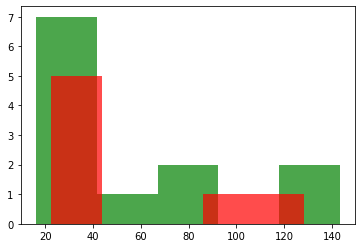

In [1021]:
game_time__1v1_stats = ranked_1v1[['treated_win', 'game_time']]
plt.hist(game_time__1v1_stats[(game_time__1v1_stats['treated_win'] == True) & (game_time__1v1_stats['game_time'] > 15) & (game_time__1v1_stats['game_time'] < 150)]['game_time'], alpha = 0.7, color = 'green', bins=5)
plt.hist(game_time__1v1_stats[(game_time__1v1_stats['treated_win'] == False) & (game_time__1v1_stats['game_time'] > 15) & (game_time__1v1_stats['game_time'] < 150)]['game_time'], alpha = 0.7, color = 'red', bins=5);

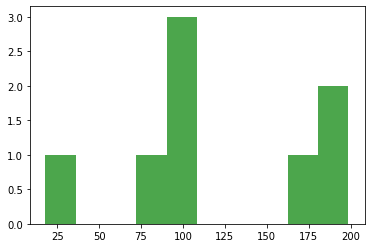

In [1031]:
game_time__tgs_stats = ranked_tgs[['treated_win', 'game_time']]
plt.hist(game_time__tgs_stats[(game_time__tgs_stats['treated_win'] == True) & (game_time__tgs_stats['game_time'] > 15) & (game_time__tgs_stats['game_time'] < 250)]['game_time'], alpha = 0.7, color = 'green')
plt.hist(game_time__tgs_stats[(game_time__tgs_stats['treated_win'] == False) & (game_time__tgs_stats['game_time'] > 15) & (game_time__tgs_stats['game_time'] < 250)]['game_time'], alpha = 0.7, color = 'red');

# Map / Civ Winrate

In [859]:
ranked_1v1_map_civ_stats = ranked_1v1.groupby(['map_type', 'own_civ'])['treated_win'].count().reset_index()
ranked_1v1_map_civ_stats.columns = ['Map', 'Civ', 'Total Games']
ranked_1v1_map_civ_stats['Wins'] = ranked_1v1.groupby(['map_type', 'own_civ'])['treated_win'].sum().values.astype(int)
ranked_1v1_map_civ_stats['Win Percentage'] = ranked_1v1.groupby(['map_type', 'own_civ'])['treated_win'].mean().values

ranked_1v1_map_civ_stats.sort_values(by = 'Total Games', ascending = False)\
.style.format("{:.0%}", subset = ['Win Percentage']).applymap(color_red_green,subset=['Win Percentage'])

,Map,Civ,Total Games,Wins,Win Percentage
9,Arabia,Mayans,6,5,83%
6,Arabia,Huns,4,2,50%
13,Four Lakes,Huns,3,3,100%
45,Serengeti,Magyars,3,0,0%
16,Four Lakes,Persians,3,2,67%
40,Nomad,Malay,2,1,50%
24,Golden Swamp,Japanese,2,0,0%
22,Golden Swamp,Celts,2,2,100%
15,Four Lakes,Malians,2,1,50%
39,Nomad,Chinese,2,2,100%


# Winrate by Server

### Ranked 1v1

In [1033]:
ranked_server_stats = ranked_1v1.groupby('server')['treated_win'].count().reset_index()
ranked_server_stats.columns = ['Server', 'Total Games']
ranked_server_stats['Wins'] = ranked_1v1.groupby('server')['treated_win'].sum().values.astype(int)
ranked_server_stats['Win Percentage'] = ranked_1v1.groupby('server')['treated_win'].mean().values

ranked_server_stats.sort_values(by = 'Total Games', ascending = False)\
.style.format("{:.0%}", subset = ['Win Percentage']).applymap(color_red_green,subset=['Win Percentage'])

,Server,Total Games,Wins,Win Percentage
4,westindia,32,18,56%
2,ukwest,15,8,53%
1,southeastasia,11,6,55%
0,brazilsouth,5,3,60%
3,westeurope,1,1,100%


### Ranked TGs

In [1034]:
ranked_server_stats = ranked_tgs.groupby('server')['treated_win'].count().reset_index()
ranked_server_stats.columns = ['Server', 'Total Games']
ranked_server_stats['Wins'] = ranked_tgs.groupby('server')['treated_win'].sum().values.astype(int)
ranked_server_stats['Win Percentage'] = ranked_tgs.groupby('server')['treated_win'].mean().values

ranked_server_stats.sort_values(by = 'Total Games', ascending = False)\
.style.format("{:.0%}", subset = ['Win Percentage']).applymap(color_red_green,subset=['Win Percentage'])

,Server,Total Games,Wins,Win Percentage
0,brazilsouth,26,18,69%
2,ukwest,23,16,70%
3,westeurope,12,7,58%
4,westindia,6,4,67%
1,southeastasia,2,2,100%
